<a href="https://colab.research.google.com/github/katjasit0815/Data-Science-academic-projects/blob/main/07_Drug_Review_rating_regression%2C_BERT_distillation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import os
import gc
import sys
import random
import time
from tabulate import tabulate

import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import html
import re

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import autocast, GradScaler
from torch.optim import AdamW
from transformers import AutoModel, AutoConfig, AutoTokenizer, get_linear_schedule_with_warmup, DataCollatorWithPadding, DistilBertModel

import accelerate
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
os.environ['PYTHONUNBUFFERED'] = '1'
os.environ["TOKENIZERS_PARALLELISM"] = "true"

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
set_seed(42)

In [ ]:
print("PyTorch видит GPU:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Имя видеокарты:", torch.cuda.get_device_name(0))
    print("Версия CUDA, которую использует PyTorch:", torch.version.cuda)

PyTorch видит GPU: True
Имя видеокарты: NVIDIA GeForce RTX 4070
Версия CUDA, которую использует PyTorch: 12.1


## EDA

In [ ]:
path = kagglehub.dataset_download("jessicali9530/kuc-hackathon-winter-2018")
print("Path to dataset files:", path)

Path to dataset files: /home/kat_sit/.cache/kagglehub/datasets/jessicali9530/kuc-hackathon-winter-2018/versions/2


In [ ]:
print(os.listdir(path))

['drugsComTrain_raw.csv', 'drugsComTest_raw.csv']


In [ ]:
df_train = pd.read_csv(path+'/drugsComTrain_raw.csv', parse_dates=['date'])
df_test = pd.read_csv(path+'/drugsComTest_raw.csv', parse_dates=['date'])

In [ ]:
df_train['split'] = 'train'
df_test['split'] = 'test'

df_all = pd.concat([df_train, df_test], ignore_index=True)

In [ ]:
df_all.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,split
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27,train
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192,train
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17,train
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10,train
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37,train


In [ ]:
print("Train shape :" ,df_train.shape)
print("Test shape :", df_test.shape)

Train shape : (161297, 8)
Test shape : (53766, 8)


In [ ]:
list_of_the_review = df_all['review'].str.split("\\s+")
length_of_the_review = list_of_the_review.str.len()
print('Информация о количестве слов в колонке review:\n')
length_of_the_review.describe()

Информация о количестве слов в колонке review:



count    215063.000000
mean         84.682228
std          44.852532
min           1.000000
25%          48.000000
50%          84.000000
75%         126.000000
max        1894.000000
Name: review, dtype: float64

In [ ]:
print(length_of_the_review.quantile(0.99))

154.0


 Как мы видим, длина 99% отзывов меньше 154 слов, а медианная длина составляет 84 слова.

In [ ]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215063 entries, 0 to 215062
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   uniqueID     215063 non-null  int64         
 1   drugName     215063 non-null  object        
 2   condition    213869 non-null  object        
 3   review       215063 non-null  object        
 4   rating       215063 non-null  int64         
 5   date         215063 non-null  datetime64[ns]
 6   usefulCount  215063 non-null  int64         
 7   split        215063 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(4)
memory usage: 13.1+ MB


Есть пропуски только в столбце condition.

In [ ]:
print(f'Дубликатов в train и test: {df_all.duplicated().sum()}')

Дубликатов в train и test: 0


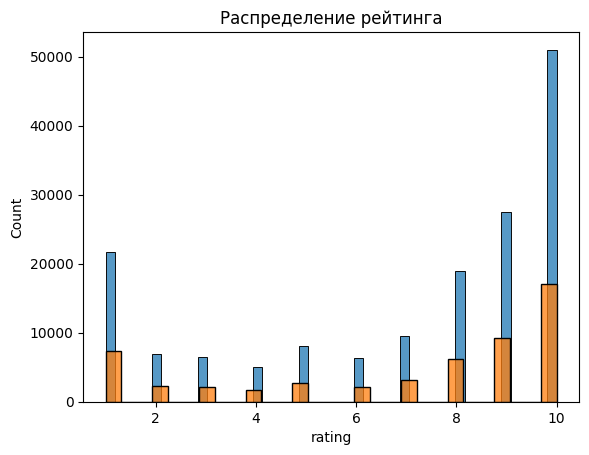

In [ ]:
sns.histplot(df_train['rating'])
sns.histplot(df_test['rating'])
plt.title("Распределение рейтинга")
plt.show()

Преобладают резко позитивные и резко отрицательные рейтинги в обоих датасетах.

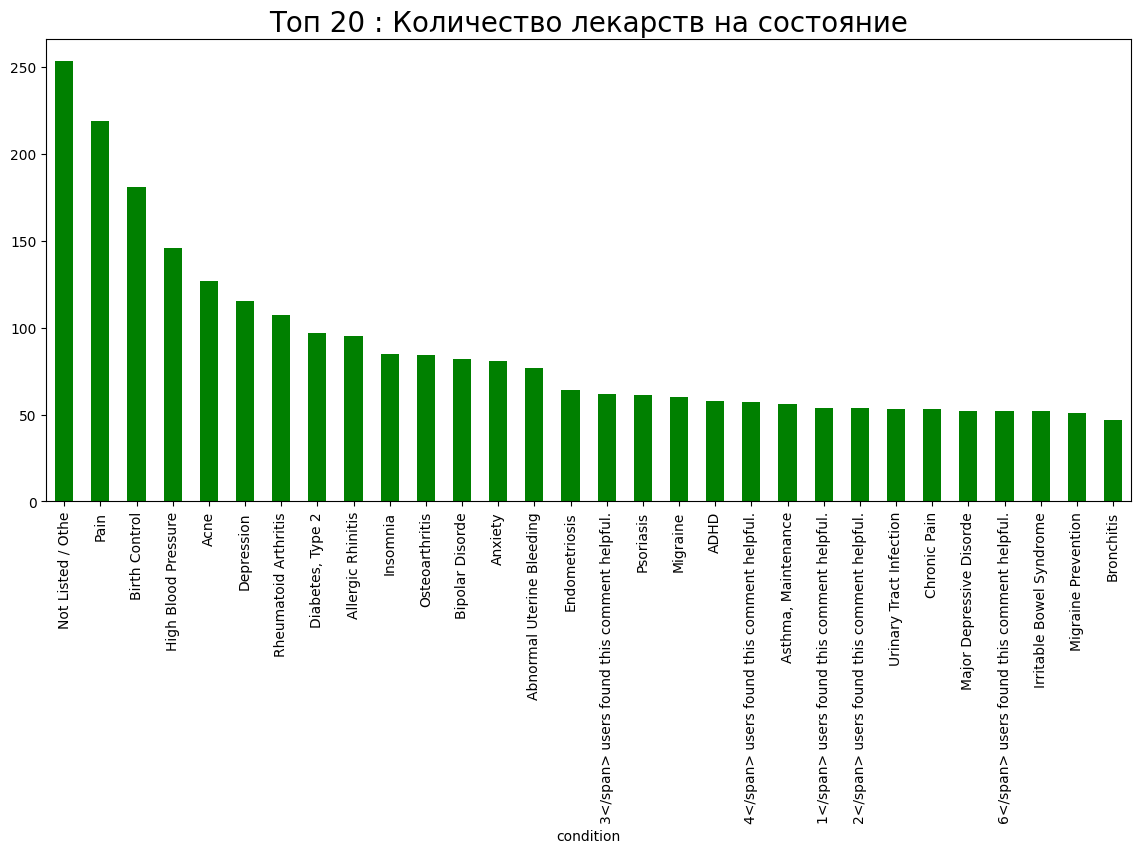

In [ ]:
condition_dn = df_all.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
condition_dn[:30].plot(kind="bar", figsize = (14,6),color="green")
plt.title("Топ 20 : Количество лекарств на состояние", fontsize = 20)
plt.show()

## Предобработка данных

Некоторые ячейки в столбце condition были заполнены неверно: 'span users found this comment useful'. Посмотрим, сколько всего таких записей + пустых:

In [ ]:
span = df_all['condition'].astype(str).str.contains('</span>').sum()
empty = df_all['condition'].isna().sum() + span
empty_perc = empty / df_all.shape[0] * 100

print(f'Пустых записей + мусорных: {empty_perc:.2f}%')

Пустых записей + мусорных: 1.10%


Так как пропусков или строк с тегами всего около 1% в обоих датасетах, удалим их далее.

Рассмотрим отдельные отзывы из стобца review:

In [ ]:
df_all['review'].loc[5]

'"2nd day on 5mg started to work with rock hard erections however experianced headache, lower bowel preassure. 3rd day erections would wake me up &amp; hurt! Leg/ankles aches   severe lower bowel preassure like you need to go #2 but can&#039;t! Enjoyed the initial rockhard erections but not at these side effects or $230 for months supply! I&#039;m 50 &amp; work out 3Xs a week. Not worth side effects!"'

In [ ]:
df_all['review'].loc[8]

'" I Ve had  nothing but problems with the Keppera : constant shaking in my arms &amp; legs &amp; pins &amp; needles feeling in my arms &amp; legs severe light headedness no appetite &amp; etc."'

Как мы видим, апостроф ' заменяется на &#039, а символ & на &amp, есть двойные кавычки, лишние пробелы. Очистим текст.

In [ ]:
def full_cleanup(df):
    df = df[~df['condition'].astype(str).str.contains('</span>',
                                                       case=False, na=False, regex=True)] # Убирает мусор из condition
    df['review'] = df['review'].apply(lambda x: html.unescape(str(x)))                    # Декодирует все HTML entities
    df['review'] = df['review'].str.strip('"\'')                                          # Убирает кавычки по краям
    df['review'] = df['review'].str.replace(r'\s+', ' ', regex=True).str.strip()          # Убирает лишние пробелы
    df = df.dropna(axis=0)                                                                # Удаляет записи с пропусками
    return df.reset_index(drop=True)

In [ ]:
df_all = full_cleanup(df_all)

In [ ]:
df_all['review'].loc[5]

"2nd day on 5mg started to work with rock hard erections however experianced headache, lower bowel preassure. 3rd day erections would wake me up & hurt! Leg/ankles aches severe lower bowel preassure like you need to go #2 but can't! Enjoyed the initial rockhard erections but not at these side effects or $230 for months supply! I'm 50 & work out 3Xs a week. Not worth side effects!"

In [ ]:
df_all['input_text'] = 'DrugName: ' + df_all['drugName'] +'. Condition: ' + df_all['condition'] + '. Review: ' + df_all['review']

In [ ]:
df_all.head()

,uniqueID,drugName,condition,review,rating,date,usefulCount,split,input_text
0,206461,Valsartan,Left Ventricular Dysfunction,"It has no side effect, I take it in combinatio...",9,2012-05-20,27,train,DrugName: Valsartan. Condition: Left Ventricul...
1,95260,Guanfacine,ADHD,My son is halfway through his fourth week of I...,8,2010-04-27,192,train,DrugName: Guanfacine. Condition: ADHD. Review:...
2,92703,Lybrel,Birth Control,"I used to take another oral contraceptive, whi...",5,2009-12-14,17,train,DrugName: Lybrel. Condition: Birth Control. Re...
3,138000,Ortho Evra,Birth Control,This is my first time using any form of birth ...,8,2015-11-03,10,train,DrugName: Ortho Evra. Condition: Birth Control...
4,35696,Buprenorphine / naloxone,Opiate Dependence,Suboxone has completely turned my life around....,9,2016-11-27,37,train,DrugName: Buprenorphine / naloxone. Condition:...


Напишем функцию, токенизирующую батчами весь входной текст, чтобы модель обращалась к уже токенизированным текстам и не тратила на это время в процессе обучения.  

Учитывая, что длина почти все текстов не превышает 154 слова, стандартное ограничение по длине отзыва в 512 токенов не будет урезать отзыв.

## Токенизация текстов

In [ ]:
tokenizer_t = AutoTokenizer.from_pretrained('microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext')
tokenizer_s = AutoTokenizer.from_pretrained('distilbert-base-uncased')

In [ ]:
def pre_tokenize_data(texts, tokenizer, max_length=512):
    input_ids = []
    attention_mask = []

    # Обрабатываем батчами
    batch_size = 1000
    for i in tqdm(range(0, len(texts), batch_size)):
        batch_texts = texts[i:i+batch_size].tolist()
        encoding = tokenizer(
            batch_texts,
            truncation=True,
            max_length=max_length,
            padding=False
        )
        input_ids.extend(encoding['input_ids'])
        attention_mask.extend(encoding['attention_mask'])

    return np.array(input_ids, dtype=object), np.array(attention_mask, dtype=object)

In [ ]:
# Разделяем обратно датасет
df_train = df_all[df_all['split'] == 'train'].drop('split', axis=1).reset_index(drop=True)
df_test = df_all[df_all['split'] == 'test'].drop('split', axis=1).reset_index(drop=True)

train_df, val_df = train_test_split(df_train, test_size=0.15, random_state=42)

print(f"Train: {len(train_df)}")
print(f"Val: {len(val_df)}")
print(f"Test: {len(df_test)}")

Train: 135573
Val: 23925
Test: 53200


In [ ]:
class ReviewDataset(Dataset):
    def __init__(self, ids, masks, labels, t_ids=None, t_masks=None):
        # Общие данные (для учителя или для ученика в режиме дистилляции)
        self.ids = ids
        self.masks = masks
        self.labels = labels

        # Данные только для учителя при дистилляции
        self.t_ids = t_ids
        self.t_masks = t_masks

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        data = {
            'input_ids': self.ids[idx],
            'attention_mask': self.masks[idx],
            'labels': float(self.labels[idx])
        }

        # Если переданы id учителя, добавляем их в словарь
        if self.t_ids is not None and self.t_masks is not None:
            data.update({
                't_input_ids': self.t_ids[idx],
                't_attention_mask': self.t_masks[idx]
            })

        return data

In [ ]:
# Токенизируем тексты для учителя
train_ids_t, train_masks_t = pre_tokenize_data(train_df['input_text'].values, tokenizer_t)
val_ids_t, val_masks_t = pre_tokenize_data(val_df['input_text'].values, tokenizer_t)
test_ids_t, test_masks_t = pre_tokenize_data(df_test['input_text'].values, tokenizer_t)

# Токенизируем тексты для ученика
train_ids_s, train_masks_s = pre_tokenize_data(train_df['input_text'].values, tokenizer_s)
val_ids_s, val_masks_s = pre_tokenize_data(val_df['input_text'].values, tokenizer_s)
test_ids_s, test_masks_s = pre_tokenize_data(df_test['input_text'].values, tokenizer_s)

# Для обучения учителя
train_dataset = ReviewDataset(train_ids_t, train_masks_t, train_df['rating'].values)
val_dataset = ReviewDataset(val_ids_t, val_masks_t, val_df['rating'].values)
test_dataset = ReviewDataset(test_ids_t, test_masks_t, df_test['rating'].values)

# Для дистилляции ученика
train_dataset_dist = ReviewDataset(
    ids=train_ids_s,
    masks=train_masks_s,
    labels=train_df['rating'].values,
    t_ids=train_ids_t,      # Данные учителя
    t_masks=train_masks_t   # Данные учителя
)

val_dataset_dist = ReviewDataset(val_ids_s, val_masks_s, val_df['rating'].values)
test_dataset_dist = ReviewDataset(test_ids_s, test_masks_s, df_test['rating'].values)

100%|███████████████████████████████████████████████████████████████████████████████████| 54/54 [00:01<00:00, 27.61it/s]


Для того, чтобы ускорить обучение и не перемножать матрицы, заполненные паддингом нулями, мы будем использовать кастомный паддинг по максимальной длине отзыва в конкретном батче.

In [ ]:
class DistilCollator:
    def __init__(self, tokenizer_s, tokenizer_t=None):
        self.tokenizer_s = tokenizer_s
        self.tokenizer_t = tokenizer_t

    def __call__(self, features):
        # Готовим данные ученика
        s_features = [{
            'input_ids': f['input_ids'],
            'attention_mask': f['attention_mask']
        } for f in features]

        batch = self.tokenizer_s.pad(s_features, return_tensors="pt")
        batch['labels'] = torch.tensor([f['labels'] for f in features], dtype=torch.float)

        # Если есть данные учителя, паддим и их
        if self.tokenizer_t is not None and 't_input_ids' in features[0]:
            t_features = [{
                'input_ids': f['t_input_ids'],
                'attention_mask': f['t_attention_mask']
            } for f in features]

            t_batch = self.tokenizer_t.pad(t_features, return_tensors="pt")
            batch['t_input_ids'] = t_batch['input_ids']
            batch['t_attention_mask'] = t_batch['attention_mask']

        return batch

# Инициализируем коллаторы
teacher_collator = DistilCollator(tokenizer_t)
distil_collator = DistilCollator(tokenizer_s, tokenizer_t)
val_collator = DistilCollator(tokenizer_s)

Создаем загрузчики данных для учителя.

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    collate_fn=teacher_collator
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    collate_fn=teacher_collator
)

test_loader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    collate_fn=teacher_collator
)

In [ ]:
class PubMedBERTRegressor(nn.Module):
    def __init__(self, model_name='microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext', dropout=0.1):
        super(PubMedBERTRegressor, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.hidden_size = self.bert.config.hidden_size
        self.dropout = nn.Dropout(dropout)
        self.regressor = nn.Linear(self.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        pooled_output = outputs.last_hidden_state[:, 0, :]  # [batch_size, 768]
        pooled_output = self.dropout(pooled_output)
        rating = self.regressor(pooled_output)  # [batch_size, 1]

        return rating.squeeze(-1)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используем устройство: {device}")

model = PubMedBERTRegressor(dropout=0.1)
model = model.to(device)

Используем устройство: cuda


In [ ]:
print("\nАрхитектура модели:")
print(model)

print(f"\nКоличество параметров: {sum(p.numel() for p in model.parameters()):,}")
print(f"Обучаемых параметров: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")


Архитектура модели:
PubMedBERTRegressor(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,),

In [ ]:
def calculate_metrics(predictions, labels):
    """Вычислить метрики регрессии"""
    rmse = np.sqrt(mean_squared_error(labels, predictions))
    mae = mean_absolute_error(labels, predictions)
    r2 = r2_score(labels, predictions)

    return {
        'rmse': rmse,
        'mae': mae,
        'r2': r2
    }

def evaluate(model, dataloader, device, criterion):
    """Оценка модели"""
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            predictions = model(input_ids, attention_mask)

            loss = criterion(predictions.view(-1), labels.view(-1))
            total_loss += loss.item()

            all_predictions.append(predictions.detach().cpu())
            all_labels.append(labels.detach().cpu())

    all_predictions = torch.cat(all_predictions).numpy().flatten()
    all_labels = torch.cat(all_labels).numpy().flatten()

    avg_loss = total_loss / len(dataloader)

    metrics = calculate_metrics(all_predictions, all_labels)
    metrics['loss'] = avg_loss

    return metrics, all_predictions, all_labels

In [ ]:
def train_epoch(model, dataloader, optimizer, scheduler, criterion, device,
                scaler, accumulation_steps=2, teacher_model=None):
    """
    Работает в 2 режимах:
    - teacher_model=None → обычное обучение
    - teacher_model=модель → дистилляция

    Args:
        model: модель для обучения (учитель или ученик)
        teacher_model: если None - обычное обучение,
                      если модель - дистилляция
        criterion: MSELoss для учителя, DistillationLoss для ученика
    """
    if teacher_model:
        teacher_model.eval()

    model.train()
    total_loss = 0
    total_hard_loss = 0  # Используется только при дистилляции
    total_soft_loss = 0  # Используется только при дистилляции
    all_predictions = []
    all_labels = []

    optimizer.zero_grad()

    desc = "Training (Distillation)" if teacher_model else "Training"
    progress_bar = tqdm(dataloader, desc=desc, file=sys.stdout)

    for i, batch in enumerate(progress_bar):

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Mixed precision forward
        with autocast():
            # Предсказание ученика
            predictions = model(input_ids, attention_mask)

            if teacher_model:
                # Берем токены учителя из того же батча
                t_input_ids = batch['t_input_ids'].to(device)
                t_attention_mask = batch['t_attention_mask'].to(device)

                # Предсказания учителя
                with torch.no_grad():
                    teacher_predictions = teacher_model(t_input_ids, t_attention_mask)

                # Дистилляция loss (передаем 3 аргумента)
                loss = criterion(predictions, labels, teacher_predictions)
            else:
                # Обычное обучение (передаем 2 аргумента)
                loss = criterion(predictions, labels)

            loss = loss / accumulation_steps

        # Backward с scaler
        scaler.scale(loss).backward()

        # Optimizer step
        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(dataloader):
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()

        total_loss += loss.item() * accumulation_steps
        all_predictions.append(predictions.detach().cpu())
        all_labels.append(labels.detach().cpu())

        if i % 10 == 0:
            current_loss = loss.item() * accumulation_steps
            if teacher_model:
                progress_bar.set_postfix({
                    "loss": f"{current_loss:.4f}",
                    "hard": f"{criterion._hard_loss:.4f}",
                    "soft": f"{criterion._soft_loss:.4f}"
                })
            else:
                progress_bar.set_postfix({"loss": f"{current_loss:.4f}"})

    # Соединяем списки тензоров в один большой тензор
    all_predictions = torch.cat(all_predictions)
    all_labels = torch.cat(all_labels)

    # Считаем средний лосс и метрики
    avg_loss = total_loss / len(dataloader)
    metrics = calculate_metrics(all_predictions, all_labels)
    metrics['loss'] = avg_loss

    return metrics

def train_model(model, train_loader, val_loader, optimizer, scheduler, scaler,
                criterion, device, epochs, accumulation_steps=2, teacher_model=None):
    """
    Полный цикл обучения

    Args:
        model: модель для обучения
        train_loader: данные для model
        val_loader: валидационные данные для model
        teacher_model: учитель (если дистилляция)
        teacher_train_loader: тренировочные данные для учителя (если дистилляция)
    """

    history = {
        'train_loss': [], 'train_rmse': [], 'train_mae': [],
        'val_loss': [], 'val_rmse': [], 'val_mae': [], 'val_r2': []
    }

    best_val_rmse = float('inf')
    best_model_path = 'best_model.pt'
    for epoch in range(epochs):
        train_metrics = train_epoch(
            model,
            train_loader,
            optimizer,
            scheduler,
            criterion,
            device,
            scaler,
            accumulation_steps,
            teacher_model=teacher_model
        )

        print(f"\nTrain - Loss: {train_metrics['loss']:.4f}, RMSE: {train_metrics['rmse']:.4f}, MAE: {train_metrics['mae']:.4f}")

        # Validation
        val_criterion = nn.MSELoss()
        val_metrics, _, _ = evaluate(model, val_loader, device, val_criterion)
        print(f"Val   - Loss: {val_metrics['loss']:.4f}, RMSE: {val_metrics['rmse']:.4f}, MAE: {val_metrics['mae']:.4f}, R²: {val_metrics['r2']:.4f}")

        # История
        for key in ['loss', 'rmse', 'mae']:
            history[f'train_{key}'].append(train_metrics[key])
            history[f'val_{key}'].append(val_metrics[key])
        history['val_r2'].append(val_metrics['r2'])

        # Сохранить лучшую модель
        if val_metrics['rmse'] < best_val_rmse:
            best_val_rmse = val_metrics['rmse']
            torch.save(model.state_dict(), 'best_model.pt')
            print(f"Модель сохранена (RMSE: {best_val_rmse:.4f})")

        gc.collect()
        torch.cuda.empty_cache()

    return history

In [ ]:
EPOCHS = 3
LEARNING_RATE = 2e-5
WARMUP_STEPS = 500
ACCUMULATION_STEPS = 2

# Loss function для регрессии
criterion = nn.MSELoss()

# Optimizer
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

# Learning rate scheduler
total_steps = (len(train_loader) // ACCUMULATION_STEPS) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=500,
    num_training_steps=total_steps
)
scaler = GradScaler()

In [ ]:
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    device=device,
    epochs=EPOCHS,
    accumulation_steps=ACCUMULATION_STEPS
)

Training: 100%|████████████████████████████████████████████████████████| 4237/4237 [59:04<00:00,  1.20it/s, loss=1.7386]

Train - Loss: 3.6633, RMSE: 1.9140, MAE: 1.3867
Val   - Loss: 2.8326, RMSE: 1.6833, MAE: 1.0853, R²: 0.7361
Сохранена лучшая модель (Val RMSE: 1.6833)
Training: 100%|████████████████████████████████████████████████████████| 4237/4237 [43:36<00:00,  1.62it/s, loss=2.7385]

Train - Loss: 2.1662, RMSE: 1.4718, MAE: 1.0347
Val   - Loss: 2.2691, RMSE: 1.5066, MAE: 1.0111, R²: 0.7886
Сохранена лучшая модель (Val RMSE: 1.5066)
Training:  35%|██████████████████                                  | 1469/4237 [1:23:00<2:36:25,  3.39s/it, loss=1.2309]


KeyboardInterrupt: 

Обучение было остановлено вручную, т.к. на третьей эпохе скорость обработки батча упала в ~3 раза. Было добавлено num_workers=2.

In [ ]:
torch.save(model.state_dict(), 'model_after_2_epochs.pt')

In [ ]:
model.load_state_dict(torch.load('model_after_2_epochs.pt'))
model.to(device)

PubMedBERTRegressor(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [ ]:
EPOCHS_REMAINING = 3

history_part2 = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    device=device,
    epochs=EPOCHS_REMAINING,
    accumulation_steps=ACCUMULATION_STEPS
)

Training:   0%|                                                                                | 0/4237 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training: 100%|██████████████████████████████████████████████████████| 4237/4237 [1:13:33<00:00,  1.04s/it, loss=1.6057]

Train - Loss: 1.6441, RMSE: 1.2822, MAE: 0.9104


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Val   - Loss: 2.2353, RMSE: 1.4953, MAE: 0.9779, R²: 0.7918
Сохранена лучшая модель (Val RMSE: 1.4953)
Training:   0%|                                                                                | 0/4237 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Training:  12%|██████▌                                                  | 488/4237 [04:21<33:31,  1.86it/s, loss=2.5214]


KeyboardInterrupt: 

Было принято решение остановить обучение после 3-й эпохи, чтобы избежать переобучения (улучшение метрик по сравнению с 2-й эпохой было очень незначительным).

Введение num_workers=2 привело к конфликту параллелизма и оказалось бесполезным. Наиболее вероятной причиной замедления на третьей эпохе обучения является  почти полная загрузка оперативной памяти из-за хранения большого количества объектов Tensor в списках.

В следующий можно попробовать добавить в train_model еще сборщик мусора gc.collect().

In [ ]:
torch.save(model.state_dict(), 'model_after_3_epochs.pt')

In [ ]:
model.load_state_dict(torch.load('model_after_3_epochs.pt'))
model.to(device)
model.eval()

test_metrics, all_predictions, all_labels = evaluate(
    model=model,
    dataloader=test_loader,
    device=device,
    criterion=criterion,

)

print(f"\nTest Results:")
print(f"Loss: {test_metrics['loss']:.4f}")
print(f"RMSE: {test_metrics['rmse']:.4f}")
print(f"MAE: {test_metrics['mae']:.4f}")
print(f"R2: {test_metrics['r2']:.4f}")

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



Test Results:
Loss: 2.2121
RMSE: 1.4872
MAE: 0.9759
R2: 0.7952


In [ ]:
rounded_preds = np.round(all_predictions)
rounded_preds = np.clip(rounded_preds, 1, 10)

new_rmse = np.sqrt(mean_squared_error(all_labels, rounded_preds))
new_mae = mean_absolute_error(all_labels, rounded_preds)
new_r2 = r2_score(all_labels, rounded_preds)

print(f"После округления:")
print(f"RMSE: {new_rmse:.4f}")
print(f"MAE: {new_mae:.4f}")
print(f"R2: {new_r2:.4f}")

После округления:
RMSE: 1.5139
MAE: 0.9336
R2: 0.7878


Посмотрим на каких примерах модель ошиблась сильнее всего.

In [ ]:
errors = np.abs(all_predictions - all_labels)

error_analysis = pd.DataFrame({
    'true_label': all_labels,
    'prediction': all_predictions,
    'MAE': errors
})

#  Добавляем тексты из тестового датасета
error_analysis['text'] = [df_test.iloc[i]['input_text'] for i in range(len(all_labels))]

# Сортируем по убыванию ошибки
top_10_errors = error_analysis.sort_values(by='MAE', ascending=False)

pd.set_option('display.max_colwidth', None)
top_10_errors.head(10)

,true_label,prediction,MAE,text
40033,1.0,10.148149,9.148149,DrugName: Fluocinolone / hydroquinone / tretinoin. Condition: Melasma. Review: I've used a lot of different products for many years but unfortunately didn't really work and I'm frustrated and gave up myself. And now my primary Doctor recommended me this Tri Luma and just for 3 weeks it really looks amazing. Very satisfied! This is really true!
12264,1.0,10.147907,9.147907,"DrugName: Sofosbuvir / velpatasvir. Condition: Hepatitis C. Review: I've had Hep c for 31 yrs, Genotype 2 , and today I just took my first pill .. Feeling hopeful to the side effects I've heard are minimal .. I will update you all in a few weeks . Thank you all for your opinions on this magical drug ."
35904,1.0,10.106522,9.106522,DrugName: Chantix. Condition: Smoking Cessation. Review: I have High Blood pressure! It was under control with medication. I was put on Chantix because I truly wanted to kick the habit. Well! for me after about 3 days I found I couldn't lift my head off the pillow without my BP dropping (well below what was normal for me.) Others I know have had no side effects and are still smoke free.
31801,1.0,10.104842,9.104842,"DrugName: Epclusa. Condition: Hepatitis C. Review: I've had Hep c for 31 yrs, Genotype 2 , and today I just took my first pill .. Feeling hopeful to the side effects I've heard are minimal .. I will update you all in a few weeks . Thank you all for your opinions on this magical drug ."
35581,1.0,10.101910,9.101910,"DrugName: Hydroxyzine. Condition: Anxiety. Review: I was prescribed this medication when I suffered a severe anxiety attack. I had mild attacks before, but I honestly thought I would die that day. I took one pill and it knocked me out for 12 hours! I was sitting in class a week later and I felt another anxiety attack coming on so, remembering what happened with the last pill, I bit the pill in half and took the smaller piece. It knocked me out for 8 hours!!! Good thing I didn't have to work that day! I have never taken anything for my anxiety previously but I wanted to get my attacks under control. I discovered meditation works best! If you have never tried it...find a local class and sit through it!! I promise it will help you find the peace you are seeking!!"
29323,1.0,10.051798,9.051798,"DrugName: Disulfiram. Condition: Alcohol Dependence. Review: I had been to AA before and had five years sobriety before going back out for twenty something years. AA really works if you have the capacity to be honest. I was fortunate enough to go back to a 30 day inpatient program. My spirituality is my cornerstone, God and faith are the only things I can depend on for my sobriety."
2246,1.0,10.038918,9.038918,DrugName: Sulfasalazine. Condition: Ulcerative Colitis. Review: The only positives I have personally is no side effects and less expensive than other medications for ulcerative colitis.
46574,1.0,10.037977,9.037977,"DrugName: Lyrica. Condition: Neuralgia. Review: I have three primary headaches types and neuralgia due to lower back injury. Intractable Migraine, migraine, chronic cluster headache and sciatic neuralgia - 1st dose ramped my 'easy' cluster headache to a 10 and my neuralgia on left side is killing me and I want to throw up. What a great freaking drug."
35891,1.0,10.026383,9.026383,DrugName: Mirvaso. Condition: Rosacea. Review: Have tried about everything for rosecea. Metrogel mirvaso lasers chamomile and finally went to get a holistic spa treatment where I got facial. She said your rosecea is bad going to use mix of rose extract oil and Moroccan oil. My redness was gone the entire day. Bought these oils online and not greasy. Not only is my rosecea under control but I have a nice healthy glow and was actually carded. The girl said I look under 40 they card under 40. I am 50 years old. My skin looks and feels younger and is so hydrated.
39287,10.0,0.989936,9.010064,DrugName: Xarelto. Condition: Atrial Fibrillation. Review: It killed my beloved mot

Из отзывов становится понятно, что в датасете присутствует шум: положительные отзывы идут в паре с крайне низкими оценками и наоборот.
Предсказания модели показывают, что она хорошо обучилась и дает логичные оценки.

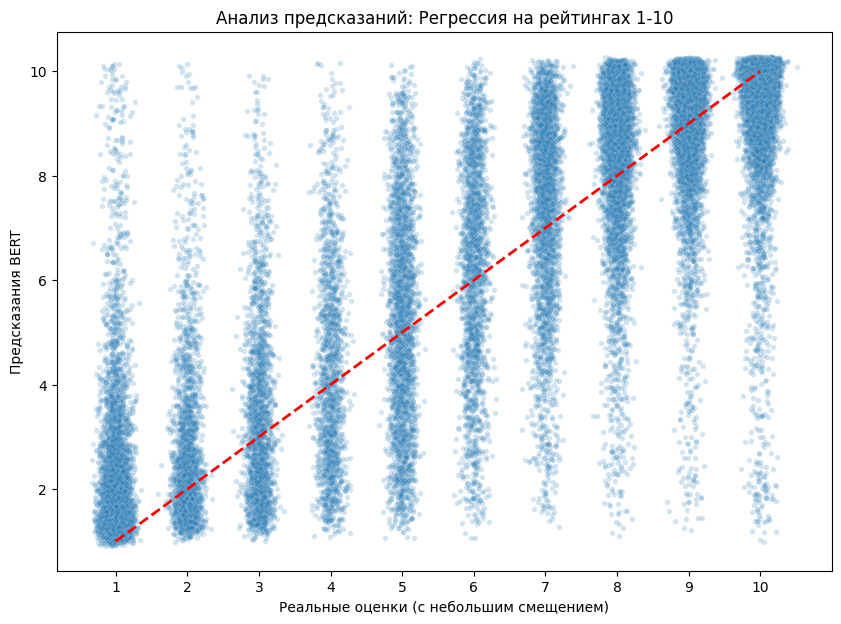

In [ ]:
jitter = np.random.normal(0, 0.1, size=len(all_labels))

plt.figure(figsize=(10, 7))
# Используем s=10 для уменьшения размера точек
sns.scatterplot(x=np.array(all_labels) + jitter, y=all_predictions, alpha=0.2, s=15)
plt.plot([1, 10], [1, 10], color='red', lw=2, linestyle='--')
plt.xticks(range(1, 11))
plt.xlabel('Реальные оценки (с небольшим смещением)')
plt.ylabel('Предсказания BERT')
plt.title('Анализ предсказаний: Регрессия на рейтингах 1-10')
plt.show()

Видно, что плотность точек выше всего там, где они пересекаются с красной пунктирной линией. Это значит, что для большинства отзывов модель предсказывает значения, близкие к реальным. Также модель четко отличает крайние степени недовольства и восторга.

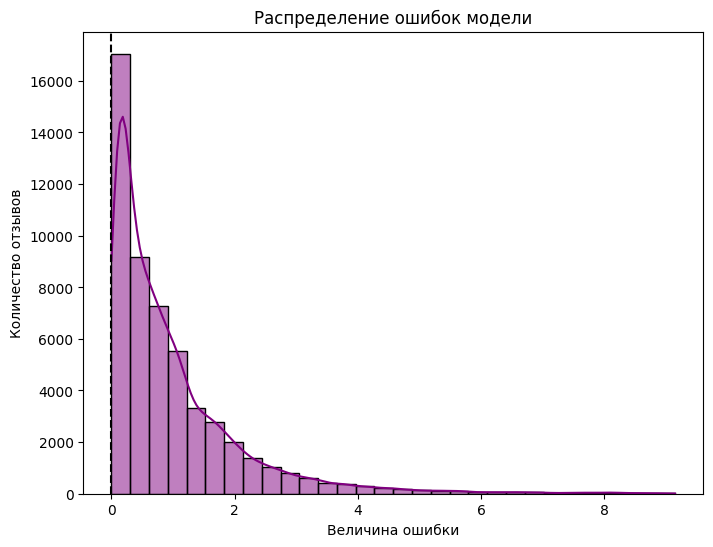

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(errors, bins=30, kde=True, color='purple')
plt.axvline(x=0, color='black', linestyle='--')
plt.xlabel('Величина ошибки')
plt.ylabel('Количество отзывов')
plt.title('Распределение ошибок модели')
plt.show()

## Дистилляция BERT

In [ ]:
class DistillationLoss(nn.Module):
    """
    Комбинированный loss для регрессии:
    - MSE с истинными метками (hard targets)
    - MSE с предсказаниями учителя (soft targets)
    """
    def __init__(self, alpha=0.4):
        super().__init__()
        self.alpha = alpha
        self.mse = nn.MSELoss()

    def forward(self, student_output, labels, teacher_output=None):
        """
        Args:
            student_output: предсказания ученика
            labels: истинные метки
            teacher_output: предсказания учителя (опционально)
        """
        hard_loss = self.mse(student_output, labels)

        if teacher_output is not None:
            soft_loss = self.mse(student_output, teacher_output.detach())
            total_loss = self.alpha * hard_loss + (1 - self.alpha) * soft_loss
            # Сохраняем для логирования
            self._hard_loss = hard_loss.item()
            self._soft_loss = soft_loss.item()
        else:
            total_loss = hard_loss
            self._hard_loss = hard_loss.item()
            self._soft_loss = 0.0

        return total_loss

In [ ]:
teacher = PubMedBERTRegressor(dropout=0.1)
state_dict = torch.load('model_after_3_epochs.pt', map_location=device)

teacher.load_state_dict(state_dict)
teacher.to(device)

PubMedBERTRegressor(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [ ]:
class DistilBERTRegressor(nn.Module):
    """Модель-ученик на основе DistilBERT"""
    def __init__(self, pretrained_name='distilbert-base-uncased', dropout=0.1):
        super(DistilBERTRegressor, self).__init__()
        self.distilbert = DistilBertModel.from_pretrained(pretrained_name)
        self.hidden_size = self.distilbert.config.hidden_size  # 768
        self.dropout = nn.Dropout(dropout)
        self.regressor = nn.Linear(self.hidden_size, 1)

    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # [CLS] token
        pooled_output = self.dropout(pooled_output)
        rating = self.regressor(pooled_output)
        return rating.squeeze(-1)

In [ ]:
train_loader_dist = DataLoader(
    train_dataset_dist,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    pin_memory=True,
    collate_fn=distil_collator # Наш кастомный коллатор
)

val_loader_dist = DataLoader(
    val_dataset_dist,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    collate_fn=val_collator
)

test_loader_dist = DataLoader(
    test_dataset_dist,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True,
    collate_fn=val_collator
)

In [ ]:
student = DistilBERTRegressor().to(device)
student.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

In [ ]:
criterion_dist = DistillationLoss(alpha=0.5)
optimizer_student = AdamW(student.parameters(), lr=1e-6, weight_decay=0.01)
scaler = GradScaler()
total_steps = (len(train_loader_dist) // ACCUMULATION_STEPS) * EPOCHS
scheduler_student = get_linear_schedule_with_warmup(
    optimizer_student,
    num_warmup_steps=500,
    num_training_steps=total_steps
)

In [ ]:
history_distil = train_model(
    model=student,
    train_loader=train_loader_dist,
    val_loader=val_loader_dist,
    optimizer=optimizer_student,
    scheduler=scheduler_student,
    criterion=criterion_dist,
    device=device,
    epochs=EPOCHS,
    accumulation_steps=ACCUMULATION_STEPS,
    teacher_model=teacher
)

Training (Distillation):   0%|                                                                 | 0/4237 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Training (Distillation): 100%|███████████████| 4237/4237 [27:43<00:00,  2.55it/s, loss=3.9394, hard=4.3670, soft=3.5118]

Train - Loss: 15.0900, RMSE: 3.8946, MAE: 2.9538


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Val   - Loss: 4.6670, RMSE: 2.1606, MAE: 1.5782, R²: 0.5652
Модель сохранена (RMSE: 2.1606)
Training (Distillation):   0%|                                                                 | 0/4237 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Training (Distillation): 100%|███████████████| 4237/4237 [57:13<00:00,  1.23it/s, loss=4.7760, hard=5.4280, soft=4.1239]

Train - Loss: 3.9408, RMSE: 2.1241, MAE: 1.5856


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Val   - Loss: 4.1424, RMSE: 2.0356, MAE: 1.4482, R²: 0.6141
Модель сохранена (RMSE: 2.0356)
Training (Distillation):   0%|                                                                 | 0/4237 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Training (Distillation): 100%|███████████████| 4237/4237 [50:52<00:00,  1.39it/s, loss=5.7049, hard=5.9949, soft=5.4149]

Train - Loss: 3.5523, RMSE: 2.0409, MAE: 1.4966


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Val   - Loss: 4.0680, RMSE: 2.0173, MAE: 1.4196, R²: 0.6210
Модель сохранена (RMSE: 2.0173)


Уменьшим параметр alpha, чтобы ученик больше опирался на логику учителя и уловил закономерности, которые вначале мог не понять.

In [ ]:
EPOCHS_REMAINING = 3
total_steps = len(train_loader_dist) * EPOCHS_REMAINING // ACCUMULATION_STEPS
scaler_student = GradScaler()
# Создаем новый шедулер, чтобы LR снова плавно снижался
scheduler_student = get_linear_schedule_with_warmup(
    optimizer_student,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

criterion_dist = DistillationLoss(alpha=0.2)
history_distil2 = train_model(
    model=student,
    train_loader=train_loader_dist,
    val_loader=val_loader_dist,
    optimizer=optimizer_student,
    scheduler=scheduler_student,
    criterion=criterion_dist,
    device=device,
    epochs=EPOCHS_REMAINING,
    scaler=scaler_student,
    accumulation_steps=ACCUMULATION_STEPS,
    teacher_model=teacher
)

Training (Distillation):   0%|                                                                 | 0/4237 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Training (Distillation): 100%|███████████████| 4237/4237 [12:46<00:00,  5.53it/s, loss=4.2191, hard=5.6601, soft=3.8588]

Train - Loss: 2.9376, RMSE: 1.9955, MAE: 1.4394


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Val   - Loss: 3.8763, RMSE: 1.9692, MAE: 1.3436, R²: 0.6388
Модель сохранена (RMSE: 1.9692)
Training (Distillation):   0%|                                                                 | 0/4237 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Training (Distillation): 100%|███████████████| 4237/4237 [15:02<00:00,  4.70it/s, loss=2.8103, hard=3.8854, soft=2.5415]

Train - Loss: 2.5753, RMSE: 1.9171, MAE: 1.3612


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Val   - Loss: 3.6547, RMSE: 1.9121, MAE: 1.2984, R²: 0.6595
Модель сохранена (RMSE: 1.9121)
Training (Distillation):   0%|                                                                 | 0/4237 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Training (Distillation): 100%|███████████████| 4237/4237 [10:06<00:00,  6.99it/s, loss=5.8604, hard=6.6842, soft=5.6545]

Train - Loss: 2.4283, RMSE: 1.8818, MAE: 1.3288


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Val   - Loss: 3.6491, RMSE: 1.9106, MAE: 1.2892, R²: 0.6600
Модель сохранена (RMSE: 1.9106)


In [ ]:
EPOCHS_REMAINING = 2
total_steps = len(train_loader_dist) * EPOCHS_REMAINING // ACCUMULATION_STEPS
scaler_student = GradScaler()
# Создаем новый шедулер, чтобы LR снова плавно снижался
scheduler_student = get_linear_schedule_with_warmup(
    optimizer_student,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

criterion_dist = DistillationLoss(alpha=0.2)
history_distil3 = train_model(
    model=student,
    train_loader=train_loader_dist,
    val_loader=val_loader_dist,
    optimizer=optimizer_student,
    scheduler=scheduler_student,
    criterion=criterion_dist,
    device=device,
    epochs=EPOCHS_REMAINING,
    scaler=scaler_student,
    accumulation_steps=ACCUMULATION_STEPS,
    teacher_model=teacher
)

Training (Distillation):   0%|                                                                 | 0/4237 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Training (Distillation): 100%|███████████████| 4237/4237 [13:58<00:00,  5.05it/s, loss=1.5717, hard=3.1533, soft=1.1763]

Train - Loss: 2.3340, RMSE: 1.8611, MAE: 1.3049


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Val   - Loss: 3.5033, RMSE: 1.8721, MAE: 1.2627, R²: 0.6736
Модель сохранена (RMSE: 1.8721)
Training (Distillation):   0%|                                                                 | 0/4237 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Training (Distillation): 100%|███████████████| 4237/4237 [15:34<00:00,  4.54it/s, loss=1.9080, hard=4.1056, soft=1.3586]

Train - Loss: 2.1676, RMSE: 1.8211, MAE: 1.2697


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Val   - Loss: 3.4695, RMSE: 1.8630, MAE: 1.2538, R²: 0.6768
Модель сохранена (RMSE: 1.8630)


In [ ]:
EPOCHS_REMAINING = 5
total_steps = len(train_loader_dist) * EPOCHS_REMAINING // ACCUMULATION_STEPS
scaler_student = GradScaler()

scheduler_student = get_linear_schedule_with_warmup(
    optimizer_student,
    num_warmup_steps=int(0.1 * total_steps),
    num_training_steps=total_steps
)

criterion_dist = DistillationLoss(alpha=0.2)
history_distil4 = train_model(
    model=student,
    train_loader=train_loader_dist,
    val_loader=val_loader_dist,
    optimizer=optimizer_student,
    scheduler=scheduler_student,
    criterion=criterion_dist,
    device=device,
    epochs=EPOCHS_REMAINING,
    scaler=scaler_student,
    accumulation_steps=ACCUMULATION_STEPS,
    teacher_model=teacher
)

Training (Distillation):   0%|                                                                 | 0/4237 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Training (Distillation): 100%|███████████████| 4237/4237 [18:04<00:00,  3.91it/s, loss=1.3273, hard=1.7751, soft=1.2153]

Train - Loss: 2.1022, RMSE: 1.8048, MAE: 1.2534


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Val   - Loss: 3.3712, RMSE: 1.8364, MAE: 1.2341, R²: 0.6859
Модель сохранена (RMSE: 1.8364)
Training (Distillation):   0%|                                                                 | 0/4237 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Training (Distillation): 100%|███████████████| 4237/4237 [12:13<00:00,  5.77it/s, loss=1.0439, hard=2.4001, soft=0.7048]

Train - Loss: 1.9497, RMSE: 1.7664, MAE: 1.2180


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Val   - Loss: 3.3237, RMSE: 1.8234, MAE: 1.2292, R²: 0.6904
Модель сохранена (RMSE: 1.8234)
Training (Distillation):   0%|                                                                 | 0/4237 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Training (Distillation): 100%|███████████████| 4237/4237 [13:21<00:00,  5.29it/s, loss=3.7988, hard=7.0487, soft=2.9863]

Train - Loss: 1.8400, RMSE: 1.7377, MAE: 1.1955


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Val   - Loss: 3.2522, RMSE: 1.8037, MAE: 1.2205, R²: 0.6970
Модель сохранена (RMSE: 1.8037)
Training (Distillation):   0%|                                                                 | 0/4237 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Training (Distillation): 100%|███████████████| 4237/4237 [12:22<00:00,  5.70it/s, loss=2.3476, hard=4.0814, soft=1.9141]

Train - Loss: 1.7657, RMSE: 1.7184, MAE: 1.1792


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Val   - Loss: 3.2419, RMSE: 1.8008, MAE: 1.2162, R²: 0.6980
Модель сохранена (RMSE: 1.8008)
Training (Distillation):   0%|                                                                 | 0/4237 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Training (Distillation): 100%|███████████████| 4237/4237 [12:57<00:00,  5.45it/s, loss=0.5227, hard=1.1341, soft=0.3698]

Train - Loss: 1.7248, RMSE: 1.7062, MAE: 1.1711


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Val   - Loss: 3.2340, RMSE: 1.7986, MAE: 1.2153, R²: 0.6987
Модель сохранена (RMSE: 1.7986)


In [ ]:
torch.save(student.state_dict(), 'student_model_best.pt')

In [ ]:
test_metrics_stud, all_predictions_stud, all_labels_stud = evaluate(
    model=student,
    dataloader=test_loader_dist,
    device=device,
    criterion=criterion_dist
)

print(f"\nTest Results:")
print(f"Loss: {test_metrics_stud['loss']:.4f}")
print(f"RMSE: {test_metrics_stud['rmse']:.4f}")
print(f"MAE: {test_metrics_stud['mae']:.4f}")
print(f"R2: {test_metrics_stud['r2']:.4f}")

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.



Test Results:
Loss: 3.2597
RMSE: 1.8054
MAE: 1.2187
R2: 0.6982


In [ ]:
rounded_preds = np.round(all_predictions_stud)
rounded_preds = np.clip(rounded_preds, 1, 10)

new_rmse_stud = np.sqrt(mean_squared_error(all_labels_stud, rounded_preds))
new_mae_stud = mean_absolute_error(all_labels_stud, rounded_preds)
new_r2_stud = r2_score(all_labels_stud, rounded_preds)

print(f"После округления:")
print(f"RMSE: {new_rmse_stud:.4f}")
print(f"MAE: {new_mae_stud:.4f}")
print(f"R2: {new_r2_stud:.4f}")

После округления:
RMSE: 1.8167
MAE: 1.1593
R2: 0.6944


## Результаты

In [ ]:
t_ids = torch.tensor(test_ids_t[0], dtype=torch.long).unsqueeze(0).to(device)
t_mask = torch.tensor(test_masks_t[0], dtype=torch.long).unsqueeze(0).to(device)

teacher_dummy = {
    'input_ids': t_ids,
    'attention_mask': t_mask
}

# Для Ученика
s_ids = torch.tensor(test_ids_s[0], dtype=torch.long).unsqueeze(0).to(device)
s_mask = torch.tensor(test_masks_s[0], dtype=torch.long).unsqueeze(0).to(device)

student_dummy = {
    'input_ids': s_ids,
    'attention_mask': s_mask
}

In [ ]:
def benchmark_models(model, inputs, device, iterations=100):
    model.to(device)
    model.eval()

    # Берем данные из переданного словаря inputs
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    with torch.no_grad():
        # 1. Разогрев
        for _ in range(10):
            # Передаем тензоры в модель
            _ = model(input_ids, attention_mask=attention_mask)

        if device.type == 'cuda':
            torch.cuda.synchronize()

        # 2. Основной замер
        start_time = time.time()
        for _ in range(iterations):
            _ = model(input_ids, attention_mask=attention_mask)
            if device.type == 'cuda':
                torch.cuda.synchronize()
        end_time = time.time()

    avg_time_ms = ((end_time - start_time) / iterations) * 1000
    return avg_time_ms

In [ ]:
time_teacher = benchmark_models(teacher, teacher_dummy, device)
time_student = benchmark_models(student, student_dummy, device)

teacher_size = os.path.getsize('model_after_3_epochs.pt') / (1024 * 1024)
student_size = os.path.getsize('student_model_best.pt') / (1024 * 1024)

In [ ]:
data = [
    {
        "Модель": "Teacher",
        "Время (мс)": time_teacher,
        "Память (МБ)": teacher_size,
        "MAE": new_mae,
        "RMSE": new_rmse,
        "R²": new_r2
    },
    {
        "Модель": "Student",
        "Время (мс)": time_student,
        "Память (МБ)": student_size,
        "MAE": new_mae_stud,
        "RMSE": new_rmse_stud,
        "R²": new_r2_stud
    }
]

print(tabulate(data, headers="keys", tablefmt="double_grid", floatfmt=".4f"))

╔══════════╦══════════════╦═══════════════╦════════╦════════╦════════╗
║ Модель   ║   Время (мс) ║   Память (МБ) ║    MAE ║   RMSE ║     R² ║
╠══════════╬══════════════╬═══════════════╬════════╬════════╬════════╣
║ Teacher  ║       4.7902 ║      417.7249 ║ 0.9336 ║ 1.5139 ║ 0.7878 ║
╠══════════╬══════════════╬═══════════════╬════════╬════════╬════════╣
║ Student  ║       2.8560 ║      253.1973 ║ 1.1593 ║ 1.8167 ║ 0.6944 ║
╚══════════╩══════════════╩═══════════════╩════════╩════════╩════════╝






1.   К дополнительной предобработке данных можно было добавить удаление слишком коротких (1-2 слова) и экстремально длинных отзывов, а также удаление отзывы с неккоректной разметкой.
2.   Несмотря на некоторые неккоретктные отзывы, модель учитель поняла общую логику выставления рейтинга и на отзывах с неккоректной разметкой показала валидные результаты.
3.   Торможение на второй эпохе обучения было связано с тем, что в train_model scaler не подавался на вход и брался в глобальном пространстве имен, что было исправлено при обучении ученика. В результате скорость обучения сократилась с 30-50 минут до ~15 минут на эпоху.
4.   Дистиллированная модель быстрее учителя в 1,7 раз, весит на 1,7 МБ меньше. Можно было продолжить обучение для получения еще более приближенных к учителю результатов.



